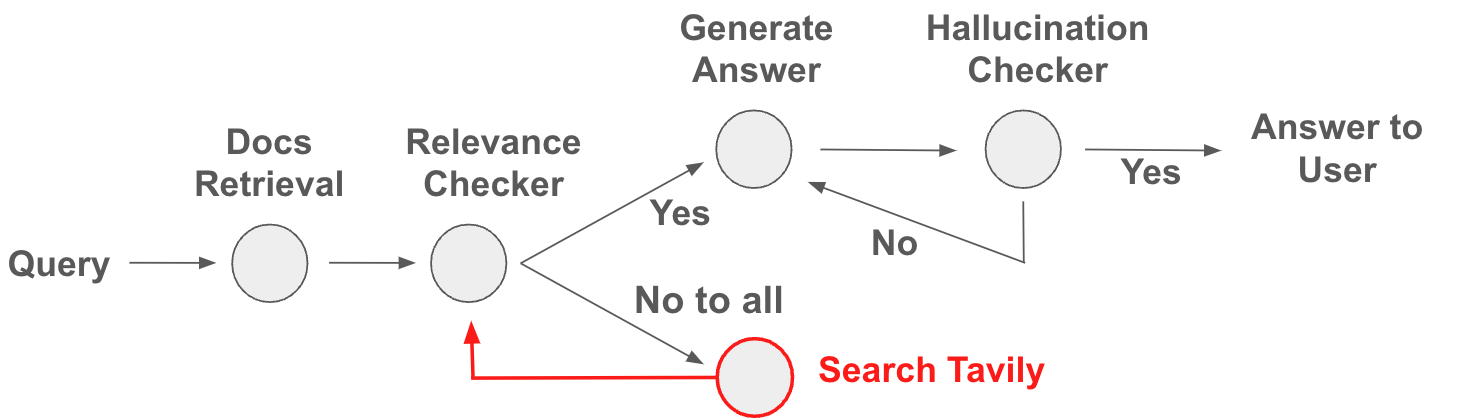

In [1]:
%%capture --no-stderr
%pip install langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python langchain-text-splitters arxiv langchain_openai pymupdf faiss-cpu

In [3]:
from langchain_openai import ChatOpenAI
import os
from getpass import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass('langchain_api_key: ')
os.environ['OPENAI_API_KEY'] = getpass('open_api_key: ')

llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0)

langchain_api_key··········
open_api_key··········


In [5]:
from tavily import TavilyClient

tavily = TavilyClient(api_key=getpass('tavily_key: '))

··········


In [4]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

### Index

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vectorstore.as_retriever()

In [38]:
from pprint import pprint
from typing import List
import json

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]


### Nodes

def retrieve(state):
    print("---RETRIEVE---")

    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)

    return {"documents": documents, "question": question}


def check_relevance(state):
    print("---RELEVANCE CHECK---")

    documents = state["documents"]
    question = state["question"]

    system = """You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "question: {question}\n\n document: {document} "),
        ]
    )

    retrieval_grader = prompt | llm | JsonOutputParser()

    # Score each doc
    filtered_docs = []
    web_search = "No"

    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score["score"]

        if grade.lower() == "yes":
            filtered_docs.append(d)

    if len(filtered_docs) == 0:
        web_search = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def decide_to_search(state):
    print("---DECIDE TO SEARCH---")

    web_search = state["web_search"]

    if web_search.lower() == "yes":
        return "search_from_tavily"
    else:
        return "generate_answer"


def search_from_tavily(state):
    print("---SEARCH TAVILY---")

    question = state["question"]

    response = tavily.search(query=question, max_results=3)
    context = [Document(page_content=json.dumps({"url": obj["url"], "content": obj["content"]})) for obj in response['results']]

    return {"documents": context}


def generate_answer(state):
    print("---GENERATE ANSWER---")

    question = state["question"]
    documents = state["documents"]

    system = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise. Add referece url or title if exist in context."""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "question: {question}\n\n context: {context} "),
        ]
    )

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})

    return {"generation": generation}


### Conditional edge

def check_hallucination(state):
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    system = """You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation."""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "documents: {documents}\n\n answer: {generation} "),
        ]
    )

    hallucination_grader = prompt | llm | JsonOutputParser()

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    if grade in ["yes", "no"]:
      return grade

    return "not supported"


In [39]:

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("search_from_tavily", search_from_tavily)
workflow.add_node("generate_answer", generate_answer)

# Set the edges
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "check_relevance")
workflow.add_conditional_edges(
    "check_relevance",
    decide_to_search,
    {
        "search_from_tavily": "search_from_tavily",
        "generate_answer": "generate_answer",
    },
)
workflow.add_edge("search_from_tavily", "check_relevance")
workflow.add_conditional_edges(
    "generate_answer",
    check_hallucination,
    {
        "yes": END,
        "no": "generate_answer",
        "not supported": "generate_answer"
    }
)

# Compile
app = workflow.compile()

In [40]:
# Test

inputs = {"question": "Who is the Faker?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
'Finished running: retrieve:'
---RELEVANCE CHECK---
---DECIDE TO SEARCH---
'Finished running: check_relevance:'
---SEARCH TAVILY---
'Finished running: search_from_tavily:'
---RELEVANCE CHECK---
---DECIDE TO SEARCH---
'Finished running: check_relevance:'
---GENERATE ANSWER---
---CHECK HALLUCINATIONS---
'Finished running: generate_answer:'
('Faker, whose real name is Lee Sang-hyeok, is a South Korean professional '
 'gamer known for playing League of Legends. He is widely regarded as one of '
 "the greatest players in the game's history, having won four World "
 'Championships and multiple domestic titles. Currently, he plays as a '
 'Midlaner for the team T1. '
 '[Source](https://www.esports.net/wiki/players/faker/)')


In [41]:
# Test

inputs = {"question": "What is in-context learning?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
'Finished running: retrieve:'
---RELEVANCE CHECK---
---DECIDE TO SEARCH---
'Finished running: check_relevance:'
---GENERATE ANSWER---
---CHECK HALLUCINATIONS---
'Finished running: generate_answer:'
('In-context learning refers to the ability of a language model to utilize '
 'short-term memory to learn from examples provided in the input prompt '
 'without updating its weights. This method allows the model to adapt its '
 'responses based on the context given at inference time, making it an '
 'empirical science that requires experimentation to optimize. For more '
 'details, you can refer to the article on [Prompt '
 'Engineering](https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/).')
